In [ ]:
# Install dependencies for Unsloth QLoRA fine-tuning
# Uninstall existing unsloth and unsloth_zoo to ensure a clean install
!pip uninstall -y unsloth unsloth_zoo

# Install a stable version of unsloth and its core dependencies
!pip install --no-cache-dir --upgrade "unsloth[colab-new]"

# Install other required dependencies
!pip install --no-deps trl peft accelerate bitsandbytes
!pip install datasets transformers  # For loading HF datasets and models

import torch
from unsloth import FastLanguageModel
from trl import SFTTrainer
from transformers import TrainingArguments, TextStreamer
from datasets import load_dataset, DatasetDict
import pandas as pd
from IPython.display import display, Markdown

# Check GPU (should be T4 or better)
!nvidia-smi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from datasets import load_dataset, Dataset
import json

# 1. Load the combined JSON file with the custom structure
print("Loading dataset...")
with open("your_dataset_path/dataset.json", "r") as f:
    data = json.load(f)

# 2. Extract the training_examples array AND reference materials from the JSON structure
training_examples = data["training_examples"]
print(f"Total examples in JSON: {len(training_examples)}")

# Extract reference materials for enhanced training
instruction_reference = data.get("instruction_reference", {})
register_map = data.get("register_map", {})
metadata = data.get("metadata", {})

print(f"Instructions available: {instruction_reference.get('total_instructions', 0)}")
print(f"Registers mapped: {register_map.get('total_registers', 0)}")
print(f"Processor: {metadata.get('processor', 'Unknown')}")

# 3. Validate and filter examples (Remove incomplete entries + clean fields)
valid_examples = []
invalid_count = 0
type_mismatch_count = 0

for idx, example in enumerate(training_examples):
    try:
        # Check if all required fields exist
        if not all(field in example for field in ["instruction", "input", "output"]):
            missing_fields = [f for f in ["instruction", "input", "output"] if f not in example]
            print(f"⚠️  Example {idx}: Missing fields - {', '.join(missing_fields)}")
            invalid_count += 1
            continue

        # Convert all main fields to strings and strip whitespace
        instruction = str(example["instruction"]).strip()
        input_code = str(example["input"]).strip()
        output_code = str(example["output"]).strip()

        # Check for empty strings
        if not instruction or not input_code or not output_code:
            print(f"⚠️  Example {idx}: Empty field detected")
            invalid_count += 1
            continue

        # Extract optional fields (context and function_name)
        function_name = example.get("function_name", "")
        context = example.get("context", {})

        # Convert context to string if it's a dict
        context_str = ""
        if isinstance(context, dict) and context:
            context_parts = []
            for key, value in context.items():
                if value:  # Only include non-empty values
                    context_parts.append(f"{key}: {value}")
            context_str = "\n".join(context_parts)

        # Create enhanced example with ALL available fields
        clean_example = {
            "instruction": instruction,
            "input": input_code,
            "output": output_code,
            "function_name": str(function_name).strip() if function_name else "",
            "context": context_str
        }

        valid_examples.append(clean_example)

    except Exception as e:
        print(f"⚠️  Example {idx}: Error during processing - {str(e)}")
        invalid_count += 1
        continue

print(f"\n✓ Valid examples: {len(valid_examples)}")
print(f"✗ Invalid examples: {invalid_count}")
print("-" * 60)

# 4. Convert to HuggingFace Dataset
if len(valid_examples) == 0:
    print("❌ ERROR: No valid examples found!")
    print("Check your JSON file structure.")
    exit(1)

try:
    dataset = Dataset.from_list(valid_examples)
    print(f"✓ Dataset created with {len(dataset)} examples")
except Exception as e:
    print(f"❌ Error creating dataset: {e}")
    print("\nDebugging info:")
    print(f"First example keys: {valid_examples[0].keys()}")
    print(f"First example types: {[(k, type(v).__name__) for k, v in valid_examples[0].items()]}")
    exit(1)

print(f"Source files: {', '.join(data['metadata']['source_files'])}")
print(f"Processor: {data['metadata']['processor']}")
print("-" * 60)

# 5. Build system context from reference materials
system_context = f"""You are an expert PIC microcontroller assembly-to-C decompiler.
Processor: {metadata.get('processor', 'PIC16F877A')}
Compiler: {metadata.get('compiler', 'MPLAB XC8')}

Key Register Mappings:
"""

# Add important registers to system context (limit to top 10 for token efficiency)
if "registers" in register_map:
    reg_items = list(register_map["registers"].items())[:10]
    for reg, desc in reg_items:
        system_context += f"- {reg}: {desc}\n"

system_context += "\nYour task is to translate PIC assembly to readable, well-commented C code.\n"

# 6. Format for instruction tuning (Enhanced Alpaca-style with context)
def format_prompt(example):
    # Start with instruction
    prompt = f"""### Instruction:
{example['instruction']}"""

    # Add function name if available
    if example.get('function_name'):
        prompt += f"\nFunction: {example['function_name']}"

    # Add context information if available
    if example.get('context'):
        prompt += f"""\n\n### Context:
{example['context']}"""

    # Add input and response
    prompt += f"""\n\n### Input:
{example['input']}\n\n### Response:
{example['output']}"""

    return {"text": prompt}

print("\nFormatting prompts...")
try:
    formatted_dataset = dataset.map(format_prompt)
    print("✓ Formatting complete")
except Exception as e:
    print(f"❌ Error during formatting: {e}")
    exit(1)

# 7. Split: 90% Train, 10% Val
train_size = int(0.9 * len(formatted_dataset))
train_dataset = formatted_dataset.select(range(train_size))
val_dataset = formatted_dataset.select(range(train_size, len(formatted_dataset)))

print(f"\nTrain Size: {len(train_dataset)}")
print(f"Val Size: {len(val_dataset)}")
print("-" * 60)

# 8. Display sample
print("\nSample training example (ENHANCED with context):")
sample_text = train_dataset[0]['text']
print(sample_text[:700] + ("..." if len(sample_text) > 700 else ""))
print("\n" + "="*60)

# 8. Statistics
print("\n📊 DATASET STATISTICS:")
print(f"  • Total valid examples: {len(dataset)}")
print(f"  • Training examples: {len(train_dataset)}")
print(f"  • Validation examples: {len(val_dataset)}")
print(f"  • Discarded examples: {invalid_count}")
print(f"  • Train/Val split: 90/10")
print("="*60 + "\n")

In [ ]:
!pip install wandb

In [ ]:
!wandb login

In [ ]:
import wandb
import os

os.environ["WANDB_API_KEY"] = "your_wandb_api_key_here"

# Initialize wandb for tracking training
run = wandb.init(
    entity="your_wandb_entity_here",
    project="PIC-Assembly-to-C-Decompiler",
    config={
        "model": "Qwen2.5-Coder-7B-Instruct-bnb-4bit",
        "learning_rate": 2e-4,
        "epochs": 5,
        "dataset_size": 199,  # Function-level pairs
        "train_size": int(199 * 0.9),
        "val_size": int(199 * 0.1),
        "lora_r": 16,
        "lora_alpha": 16,
        "max_seq_length": 1024,
        "pairing_level": "function",  # Complete functions, not line-by-line
    },
)
print(f"Wandb run initialized: {run.name}")

In [ ]:
max_seq_length = 2048  # Adjust based on your asm length
dtype = None  # Auto-detect (float16 for T4)

model, tokenizer = FastLanguageModel.from_pretrained(
    "unsloth/Qwen2.5-Coder-7B-Instruct-bnb-4bit",  # Or "unsloth/DeepSeek-Coder-V2-Lite-Instruct-bnb-4bit" if preferred
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=True,
)

# Add LoRA adapters (minimal config for efficiency)
model = FastLanguageModel.get_peft_model(
    model,
    r=16,  # Low rank
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=42,
)

In [ ]:
# Training args: Simple, short training for college demo
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    dataset_text_field="text",  # Our formatted field
    max_seq_length=max_seq_length,
    args=TrainingArguments(
        per_device_train_batch_size=1,  # Reduced for even smaller memory footprint
        gradient_accumulation_steps=4,
        warmup_steps=5,
        max_steps=300,  # ~1 epoch for small dataset; adjust to 100-200 for longer
        learning_rate=2e-4,
        fp16=not torch.cuda.is_bf16_supported(),
        bf16=torch.cuda.is_bf16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=42,
        output_dir="outputs",
    ),
)

# Train!
trainer.train()

# Save LoRA adapters (small file)
model.save_pretrained("fine_tuned_model")
tokenizer.save_pretrained("fine_tuned_model")

In [ ]:
import torch
from transformers import TextStreamer
import gc

# 1. SETUP: Define the generate function with enhanced context
def generate_c(assembly, model, tokenizer, function_name="", context=""):
    prompt = f"""### Instruction:
Decompile the following PIC16F877A assembly to readable C code. Rename variables meaningfully and add comments."""

    if function_name:
        prompt += f"\nFunction: {function_name}"

    if context:
        prompt += f"\n\n### Context:\n{context}"

    prompt += f"""\n\n### Input:
{assembly}

### Response:
"""
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    # We turn off the streamer for the loop to keep output clean
    outputs = model.generate(**inputs, max_new_tokens=512, use_cache=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True).split("### Response:")[-1].strip()

# ==========================================
# PHASE 1: TEST FINE-TUNED MODEL
# ==========================================
print("--- Testing Fine-Tuned Model ---")

# (The model is likely already loaded from your training cell.
# If not, uncomment the next two lines)
model, tokenizer = FastLanguageModel.from_pretrained("fine_tuned_model")
FastLanguageModel.for_inference(model)

# Store results temporarily
comparison_data = []

# Determine how many validation examples to test (max 5, or all if less)
num_test_examples = min(5, len(val_dataset))
print(f"Testing on {num_test_examples} validation examples (out of {len(val_dataset)} total)")

# Loop through validation set
for i, example in enumerate(val_dataset.select(range(num_test_examples))):
    # Extract original example data (before formatting)
    original_example = valid_examples[train_size + i]
    asm_input = original_example['input']
    ground_truth = original_example['output']
    function_name = original_example.get('function_name', '')
    context = original_example.get('context', '')

    print(f"\nGenerating Fine-Tuned result for Example {i+1}...")
    ft_output = generate_c(asm_input, model, tokenizer, function_name, context)

    comparison_data.append({
        "input": asm_input,
        "ground_truth": ground_truth,
        "function_name": function_name,
        "context": context,
        "ft_output": ft_output
    })

# ==========================================
# PHASE 2: CLEAR MEMORY (CRITICAL STEP)
# ==========================================
print("\nCleaning up GPU memory...")
del model
del tokenizer
gc.collect()
torch.cuda.empty_cache()

# ==========================================
# PHASE 3: TEST BASE MODEL
# ==========================================
print("--- Testing Base Model ---")
base_model, base_tokenizer = FastLanguageModel.from_pretrained(
    "unsloth/Qwen2.5-Coder-7B-Instruct-bnb-4bit",
    load_in_4bit=True,
)
FastLanguageModel.for_inference(base_model)

# Loop through the SAME data again with the base model
for i, data in enumerate(comparison_data):
    print(f"Generating Base Model result for Example {i+1}...")
    base_output = generate_c(data['input'], base_model, base_tokenizer,
                            data.get('function_name', ''), data.get('context', ''))

    # CRITICAL: Store the base output in the dictionary
    data['base_output'] = base_output

    # Print the final comparison
    print("="*60)
    print(f"EXAMPLE {i+1}")
    print(f"INPUT ASM:      {data['input'][:100]}...")
    print("-" * 20)
    print(f"GROUND TRUTH:   {data['ground_truth']}")
    print("-" * 20)
    print(f"BASE MODEL:     {base_output}")
    print("-" * 20)
    print(f"FINE-TUNED:     {data['ft_output']}")
    print("="*60)


--- Testing Fine-Tuned Model ---
==((====))==  Unsloth 2026.1.4: Fast Qwen2 patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.6.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.34. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Testing on 5 validation examples (out of 22 total)

Generating Fine-Tuned result for Example 1...

Generating Fine-Tuned result for Example 2...


Unsloth: Input IDs of shape torch.Size([1, 2572]) with length 2572 > the model's max sequence length of 2048.
We shall truncate it ourselves. It's imperative if you correct this issue first.



Generating Fine-Tuned result for Example 3...

Generating Fine-Tuned result for Example 4...

Generating Fine-Tuned result for Example 5...

Cleaning up GPU memory...
--- Testing Base Model ---
==((====))==  Unsloth 2026.1.4: Fast Qwen2 patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.6.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.34. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Generating Base Model result for Example 1...
EXAMPLE 1
INPUT ASM:      _ISR:
	btfss	11,1	;volatile
	goto	u1_21
	goto	u1_20
u1_21:
	goto	i1l18
u1_20:
	bcf	11,1	;volatile
	m...
--------------------
GROUND TRUTH:   void __interrupt() ISR(void) {
    if (INTCONbits.INTF == 1) {
        INTCONbits.INTF = 0; // Clear Flag
        
        PORTC = 0xFF;     

In [ ]:
# Pandas table for clean visualization
df = pd.DataFrame(comparison_data)
display(df)  # Shows interactive table in Colab

,input,ground_truth,function_name,context,ft_output,base_output
0,"_ISR:\n\tbtfss\t11,1\t;volatile\n\tgoto\tu1_21...",void __interrupt() ISR(void) {\n if (INTCON...,_ISR,"registers_used: ['INTCON (11)', 'PORTC (7)', '...",void __interrupt() ISR(void) {\n if(INTF) {...,:
1,"_main:\n\tbsf\t3,5\t;RP0=1, select bank1\n\tbc...",void main() {\n TRISD = 0x00; // Output\n ...,_main,"registers_used: ['TRISD (136 / 0x88)', 'TRISB ...",void main() {\n TRISD = 0x00; // Output\n ...,```c\n#include <xc.h>\n\nvoid main(void) {\n ...
2,"_main:\n\tmovlw\t255\n\tbsf\t3,5\t;RP0=1, sele...",void main() {\n // Setup\n TRISA = 0xFF;...,_main,"registers_used: ['TRISA (133)', 'TRISB (134)',...",void main() {\n TRISA = 0xFF;\n TRISB = ...,goto\tl1231\n```\n\n\n\n\n\ns
3,"_lift_up:\n\tmovlw\t96\n\tbcf\t3,5\n\tbcf\t3,6...",void lift_up() {\n PORTB = 0x60;\n __del...,_lift_up,registers_used: ['PORTB (6)']\nstepper_sequenc...,void lift_up() {\n PORTB = 0b01100000; // M...,```c\n// Lift up function for stepper motor co...
4,_door_open:\n\tclrf\tdoor_open@j\n\tclrf\tdoor...,void door_open() {\n unsigned int j;\n f...,_door_open,registers_used: ['PORTC (7) - RC0 is the servo...,void door_open() {\n int j;\n \n for(...,```


In [ ]:
# Install evaluation metrics
!pip install sacrebleu rouge-score evaluate -q

import torch
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from difflib import SequenceMatcher
from collections import Counter
import re

# ==========================================
# CLEAR GPU MEMORY BEFORE METRICS
# ==========================================
print("Cleaning up GPU memory before metrics calculation...")
try:
    del base_model
    del base_tokenizer
except:
    pass
gc.collect()
torch.cuda.empty_cache()
print("GPU memory cleared ✓\n")

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# ==========================================
# EVALUATION METRICS FUNCTIONS
# ==========================================

# def calculate_exact_match(ground_truth, generated):
#     """Check if generated code exactly matches ground truth."""
#     return 1.0 if ground_truth.strip() == generated.strip() else 0.0

def calculate_token_accuracy(ground_truth, generated):
    """Calculate token-level accuracy."""
    gt_tokens = ground_truth.split()
    gen_tokens = generated.split()

    if len(gt_tokens) == 0:
        return 0.0

    matches = sum(1 for i in range(min(len(gt_tokens), len(gen_tokens)))
                  if gt_tokens[i] == gen_tokens[i])
    return matches / max(len(gt_tokens), len(gen_tokens))

def calculate_code_similarity(ground_truth, generated):
    """Calculate sequence similarity using SequenceMatcher."""
    return SequenceMatcher(None, ground_truth, generated).ratio()

def extract_function_names(code):
    """Extract function names from C code."""
    pattern = r'\b(?:void|int|char|float|double|long|short)\s+(\w+)\s*\('
    return re.findall(pattern, code)

def calculate_function_name_accuracy(ground_truth, generated):
    """Check if function names match."""
    gt_funcs = set(extract_function_names(ground_truth))
    gen_funcs = set(extract_function_names(generated))

    if len(gt_funcs) == 0:
        return 1.0

    matches = len(gt_funcs & gen_funcs)
    return matches / len(gt_funcs)

def calculate_keyword_accuracy(ground_truth, generated):
    """Calculate accuracy of C keywords (if, while, for, return, etc.)."""
    keywords = ['if', 'while', 'for', 'return', 'void', 'int', 'char', 'struct', 'switch', 'case']

    gt_keywords = Counter([word for word in ground_truth.split() if word in keywords])
    gen_keywords = Counter([word for word in generated.split() if word in keywords])

    if sum(gt_keywords.values()) == 0:
        return 1.0

    matches = sum((gt_keywords & gen_keywords).values())
    total = sum(gt_keywords.values())
    return matches / total

# ==========================================
# CALCULATE METRICS FOR ALL EXAMPLES
# ==========================================

print("="*60)
print("CALCULATING EVALUATION METRICS")
print("="*60)

base_metrics = {
    # 'exact_match': [],
    'token_accuracy': [],
    'code_similarity': [],
    'function_accuracy': [],
    'keyword_accuracy': []
}

ft_metrics = {
    # 'exact_match': [],
    'token_accuracy': [],
    'code_similarity': [],
    'function_accuracy': [],
    'keyword_accuracy': []
}

# Calculate metrics for each example
for i, data in enumerate(comparison_data):
    gt = data['ground_truth']
    base = data['base_output']
    ft = data['ft_output']

    # Base model metrics
    # base_metrics['exact_match'].append(calculate_exact_match(gt, base))
    base_metrics['token_accuracy'].append(calculate_token_accuracy(gt, base))
    base_metrics['code_similarity'].append(calculate_code_similarity(gt, base))
    base_metrics['function_accuracy'].append(calculate_function_name_accuracy(gt, base))
    base_metrics['keyword_accuracy'].append(calculate_keyword_accuracy(gt, base))

    # Fine-tuned model metrics
    # ft_metrics['exact_match'].append(calculate_exact_match(gt, ft))
    ft_metrics['token_accuracy'].append(calculate_token_accuracy(gt, ft))
    ft_metrics['code_similarity'].append(calculate_code_similarity(gt, ft))
    ft_metrics['function_accuracy'].append(calculate_function_name_accuracy(gt, ft))
    ft_metrics['keyword_accuracy'].append(calculate_keyword_accuracy(gt, ft))

    print(f"\nExample {i+1}:")
    print(f"  Base Model     - Similarity: {base_metrics['code_similarity'][-1]:.2%}")
    print(f"  Fine-Tuned     - Similarity: {ft_metrics['code_similarity'][-1]:.2%}")
    print(f"  Improvement:   {(ft_metrics['code_similarity'][-1] - base_metrics['code_similarity'][-1]):.2%}")

# ==========================================
# AGGREGATE METRICS
# ==========================================

print("\n" + "="*60)
print("AGGREGATE PERFORMANCE METRICS")
print("="*60)

metrics_summary = []
for metric_name in base_metrics.keys():
    base_avg = np.mean(base_metrics[metric_name]) * 100
    ft_avg = np.mean(ft_metrics[metric_name]) * 100
    improvement = ft_avg - base_avg

    metrics_summary.append({
        'Metric': metric_name.replace('_', ' ').title(),
        'Base Model (%)': f"{base_avg:.2f}",
        'Fine-Tuned (%)': f"{ft_avg:.2f}",
        'Improvement (%)': f"{improvement:+.2f}"
    })

    print(f"\n{metric_name.replace('_', ' ').title()}:")
    print(f"  Base Model:     {base_avg:.2f}%")
    print(f"  Fine-Tuned:     {ft_avg:.2f}%")
    print(f"  Improvement:    {improvement:+.2f}%")

# Create summary DataFrame
metrics_df = pd.DataFrame(metrics_summary)
print("\n" + "="*60)
print("SUMMARY TABLE")
print("="*60)
display(metrics_df)

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.8/100.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.2 MB/s eta 0:00:00
Cleaning up GPU memory before metrics calculation...
GPU memory cleared ✓

CALCULATING EVALUATION METRICS

Example 1:
  Base Model     - Similarity: 0.00%
  Fine-Tuned     - Similarity: 51.78%
  Improvement:   51.78%

Example 2:
  Base Model     - Similarity: 7.97%
  Fine-Tuned     - Similarity: 72.66%
  Improvement:   64.69%

Example 3:
  Base Model     - Similarity: 0.96%
  Fine-Tuned     - Similarity: 10.78%
  Improvement:   9.82%

Example 4:
  Base Model     - Similarity: 6.42%
  Fine-Tuned     - Similarity: 49.17%
  Improvement:   42.76%

Example 5:
  Base Model     - Similarity: 0.00%
  Fine-Tuned     - Similarity: 25.54%
  Improvement:   25.54%

AGGREGATE PERFORMANCE METRICS

Token Accuracy:
  Base Model:     0.11%
  Fine-Tuned:     10.87%
  Improvement:    +10.76%

Code Similarity:

,Metric,Base Model (%),Fine-Tuned (%),Improvement (%)
0,Token Accuracy,0.11,10.87,+10.76
1,Code Similarity,3.07,41.98,+38.92
2,Function Accuracy,40.00,100.00,+60.00
3,Keyword Accuracy,40.00,60.00,+20.00


/tmp/ipython-input-4153709795.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax3.boxplot([base_metrics['code_similarity'], ft_metrics['code_similarity']],



✅ Performance plots saved as 'performance_comparison.png'


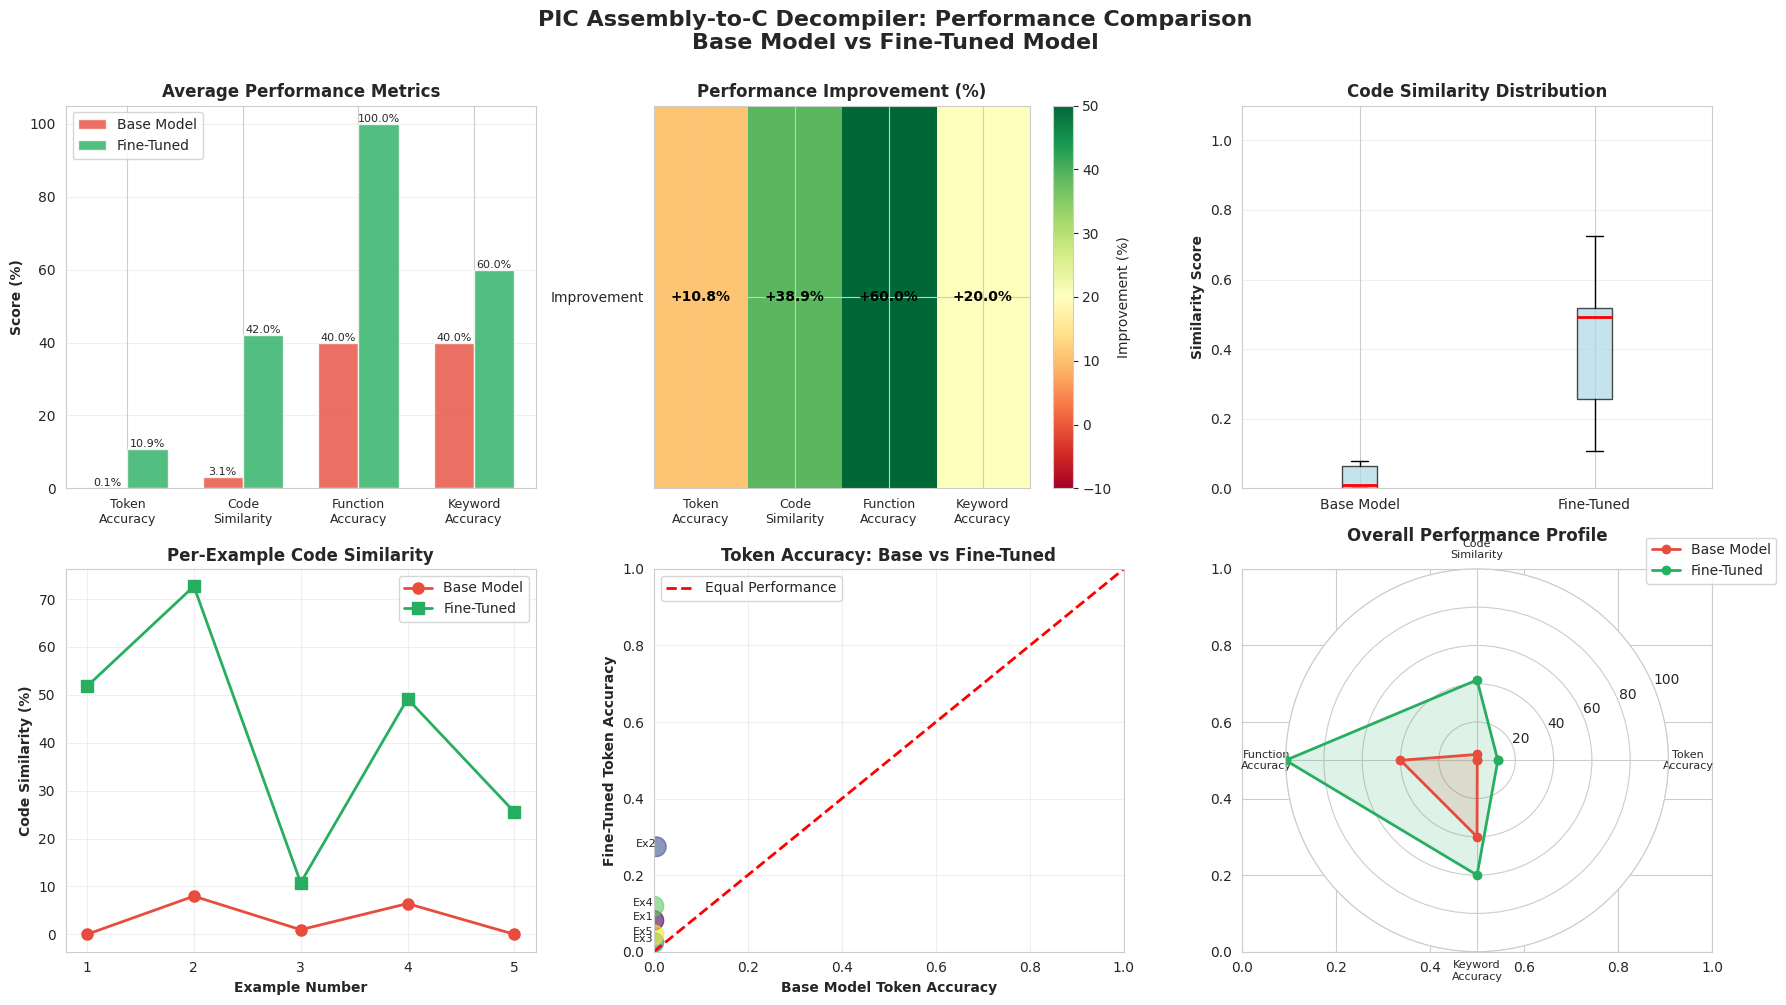


📊 FINAL PERFORMANCE SUMMARY

🔴 Base Model Average Score:       20.79%
🟢 Fine-Tuned Model Average Score: 53.21%
📈 Overall Improvement:            +32.42%
📊 Relative Improvement:           +155.9%

✅ Evaluation Complete!


In [ ]:
# ==========================================
# VISUALIZATION: PERFORMANCE COMPARISON PLOTS
# ==========================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('PIC Assembly-to-C Decompiler: Performance Comparison\nBase Model vs Fine-Tuned Model',
             fontsize=16, fontweight='bold', y=1.00)

# Plot 1: Bar Chart - Average Metrics Comparison
ax1 = axes[0, 0]
metric_names = [name.replace('_', '\n').title() for name in base_metrics.keys()]
base_avgs = [np.mean(base_metrics[key]) * 100 for key in base_metrics.keys()]
ft_avgs = [np.mean(ft_metrics[key]) * 100 for key in ft_metrics.keys()]

x = np.arange(len(metric_names))
width = 0.35

bars1 = ax1.bar(x - width/2, base_avgs, width, label='Base Model', color='#e74c3c', alpha=0.8)
bars2 = ax1.bar(x + width/2, ft_avgs, width, label='Fine-Tuned', color='#27ae60', alpha=0.8)

ax1.set_ylabel('Score (%)', fontweight='bold')
ax1.set_title('Average Performance Metrics', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metric_names, fontsize=9)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=8)

# Plot 2: Improvement Heatmap
ax2 = axes[0, 1]
improvements = [[ft_avgs[i] - base_avgs[i] for i in range(len(base_avgs))]]
im = ax2.imshow(improvements, cmap='RdYlGn', aspect='auto', vmin=-10, vmax=50)
ax2.set_xticks(range(len(metric_names)))
ax2.set_xticklabels(metric_names, fontsize=9, rotation=0)
ax2.set_yticks([0])
ax2.set_yticklabels(['Improvement'])
ax2.set_title('Performance Improvement (%)', fontweight='bold')

# Add text annotations
for i in range(len(metric_names)):
    text = ax2.text(i, 0, f'{improvements[0][i]:+.1f}%',
                   ha="center", va="center", color="black", fontweight='bold')

plt.colorbar(im, ax=ax2, label='Improvement (%)')

# Plot 3: Code Similarity Distribution
ax3 = axes[0, 2]
ax3.boxplot([base_metrics['code_similarity'], ft_metrics['code_similarity']],
            labels=['Base Model', 'Fine-Tuned'],
            patch_artist=True,
            boxprops=dict(facecolor='lightblue', alpha=0.7),
            medianprops=dict(color='red', linewidth=2))
ax3.set_ylabel('Similarity Score', fontweight='bold')
ax3.set_title('Code Similarity Distribution', fontweight='bold')
ax3.set_ylim([0, 1.1])
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Per-Example Comparison
ax4 = axes[1, 0]
examples = list(range(1, len(comparison_data) + 1))
ax4.plot(examples, [s * 100 for s in base_metrics['code_similarity']],
         marker='o', label='Base Model', linewidth=2, markersize=8, color='#e74c3c')
ax4.plot(examples, [s * 100 for s in ft_metrics['code_similarity']],
         marker='s', label='Fine-Tuned', linewidth=2, markersize=8, color='#27ae60')
ax4.set_xlabel('Example Number', fontweight='bold')
ax4.set_ylabel('Code Similarity (%)', fontweight='bold')
ax4.set_title('Per-Example Code Similarity', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_xticks(examples)

# Plot 5: Token Accuracy Comparison
ax5 = axes[1, 1]
ax5.scatter(base_metrics['token_accuracy'], ft_metrics['token_accuracy'],
           s=200, alpha=0.6, c=range(len(comparison_data)), cmap='viridis')
ax5.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Equal Performance')
ax5.set_xlabel('Base Model Token Accuracy', fontweight='bold')
ax5.set_ylabel('Fine-Tuned Token Accuracy', fontweight='bold')
ax5.set_title('Token Accuracy: Base vs Fine-Tuned', fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)
ax5.set_xlim([0, 1])
ax5.set_ylim([0, 1])

# Annotate points
for i, (x, y) in enumerate(zip(base_metrics['token_accuracy'], ft_metrics['token_accuracy'])):
    ax5.annotate(f'Ex{i+1}', (x, y), fontsize=8, ha='right')

# Plot 6: Overall Performance Radar Chart
ax6 = axes[1, 2]
categories = [name.replace('_', '\n').title() for name in base_metrics.keys()]
N = len(categories)

angles = [n / float(N) * 2 * np.pi for n in range(N)]
base_values = base_avgs + [base_avgs[0]]
ft_values = ft_avgs + [ft_avgs[0]]
angles += angles[:1]

ax6 = plt.subplot(2, 3, 6, projection='polar')
ax6.plot(angles, base_values, 'o-', linewidth=2, label='Base Model', color='#e74c3c')
ax6.fill(angles, base_values, alpha=0.15, color='#e74c3c')
ax6.plot(angles, ft_values, 'o-', linewidth=2, label='Fine-Tuned', color='#27ae60')
ax6.fill(angles, ft_values, alpha=0.15, color='#27ae60')

ax6.set_xticks(angles[:-1])
ax6.set_xticklabels(categories, fontsize=8)
ax6.set_ylim(0, 100)
ax6.set_title('Overall Performance Profile', fontweight='bold', pad=20)
ax6.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax6.grid(True)

plt.tight_layout()
plt.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
print("\n✅ Performance plots saved as 'performance_comparison.png'")
plt.show()

# ==========================================
# SUMMARY STATISTICS
# ==========================================

print("\n" + "="*60)
print("📊 FINAL PERFORMANCE SUMMARY")
print("="*60)

overall_base = np.mean([np.mean(base_metrics[key]) for key in base_metrics.keys()]) * 100
overall_ft = np.mean([np.mean(ft_metrics[key]) for key in ft_metrics.keys()]) * 100
overall_improvement = overall_ft - overall_base

print(f"\n🔴 Base Model Average Score:       {overall_base:.2f}%")
print(f"🟢 Fine-Tuned Model Average Score: {overall_ft:.2f}%")
print(f"📈 Overall Improvement:            {overall_improvement:+.2f}%")
print(f"📊 Relative Improvement:           {(overall_improvement/overall_base)*100:+.1f}%")

print("\n" + "="*60)
print("✅ Evaluation Complete!")
print("="*60)